# xGoals

Initial version created: 05/02/2023

In this notebook, a xGoals model is developed using shots data from SciSports. The following variables are used to predict the probability of a shot resulting in a goal:
* body part with which the shot was taken
* x coordinate for the location where the action started
* y coordinate for the location where the action started
* angle between shot location and goal posts
* distance between shot location and goal

The model is limited in that it lacks features that have been proven to significantly impact the probability of a shot resulting in a goal, such as, for example, the height of the ball when the shot was taken, the position of defenders and the goalkeeper.

In [2]:
# Importing relevant libraries
import os
import pyarrow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial import distance
from math import atan2, pi
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import average_precision_score, roc_auc_score
from scikitplot.metrics import plot_precision_recall_curve, plot_roc_curve

## Read data

In [5]:
path = os.path.abspath(os.path.join(os.sep, os.getcwd(), os.pardir, 'ssda-how-to-expected-goals/data', 'scisports-shots.parquet'))
df_shots = pd.read_parquet(path,engine='pyarrow')

## Data pre-processing

### Normalize the location features

In [6]:
# normalizing the location features
for action in ['action','action1']:
    for side in ['start', 'end']:
        
        # Normalize the X location
        key_x = '{}_{}_x'.format(action, side)
        df_shots[key_x] = df_shots[key_x] / 105
               
        # Normalize the Y location
        key_y = '{}_{}_y'.format(action, side)
        df_shots[key_y] = df_shots[key_y] / 68

In [4]:
# Normalized location for the center of the opposing goal
goal = (1, 0.5)

# Normalized location for the goal posts
left_post = (1,0.45)
right_post = (1,0.55)

### Calculate additional features

In [5]:
for action in ['action']:
    key_start_x = f"{action}_start_x"
    key_start_y = f"{action}_start_y"
    key_start_distance = f"{action}_start_distance"

    # Calculating the distances between shot starting point and center of opposing goal
    df_shots[key_start_distance] = df_shots.apply(lambda s: distance.euclidean([s[key_start_x]], [s[key_start_y]], goal), axis=1)

In [6]:
# Calculating the angle between shot position and goal posts
# TODO: outsource function to lib file
def rad_to_deg(rad):
    return rad * 180 / pi

def coords_angle(action_start_x, action_start_y):
    angle_1 = atan2(left_post[1] - action_start_y, left_post[0] - action_start_x)
    angle_2 = atan2(right_post[1] - action_start_y, right_post[0] - action_start_x)
    # laut discord-Hilfe: angle_1 - angle_2 > Ergebnisse sehen komisch aus
    angle = rad_to_deg(angle_2 - angle_1)
    return (angle + 360) if angle < 0 else angle

df_shots['angle'] = df_shots[['action_start_x','action_start_y']].apply( lambda row : coords_angle(row.action_start_x,row.action_start_y) , axis = 1)

### Construct the dataset for the model

In [7]:
# Features
columns_features = ['action_start_x', 'action_start_y', 'action_body_part_id', 'action_start_distance', 'angle']
# Label: 1 if a goal, 0 otherwise
column_target = 'action_result'

In [8]:
# Define X and y to use in the model
X = df_shots[columns_features]
y = df_shots[column_target]

### Split dataset into train and test set

In [9]:
# The model is trained on 80% of the data and evaluated on the remaining 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

## Train the model

In [11]:
# Define parameters for the model
params = { 'max_depth': [3, 5, 6],
           'learning_rate': [0.01, 0.1, 0.3],
           'subsample': np.arange(0.5, 0.9),
           'colsample_bytree': np.arange(0.5, 0.9),
           'colsample_bylevel': np.arange(0.5, 0.9),
           'n_estimators': [100, 500, 1000]}

# Define classifier
classifier = XGBClassifier()

# Use Random Search to optimize hyperparameters
model = RandomizedSearchCV(estimator=classifier,
                         param_distributions=params,
                         scoring='roc_auc',
                         n_iter=20,
                         verbose=1)

# Fit model
model.fit(X_train, y_train)

# Print the best hyperparameters found
print(f"Best hyperparameters found by RandomizedSearchCV: {model.best_params_}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters found by RandomizedSearchCV: {'subsample': 0.5, 'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5}


## Evaluate the model

In [14]:
# Predict probability of each shot resulting in a goal
y_pred = model.predict_proba(X_test)

In [15]:
# Count total and positives
y_total = y_train.count()
y_positive = y_train.sum()

print('{} examples of {} of the training set are positives.'.format(y_positive, y_total))

10807 examples of 102114 of the training set are positives.


The ratio of positives in the training set indicates that the data is rather imbalanced. That is, the AUC-PR and ROC-AUC scores are calculated as they are particularly useful for imbalanced classes.

### Calculate PR AUC score

In [17]:
auc_pr = average_precision_score(y_test, y_pred[:, 1])

print('The classifier obtains an AUC-PR of {}.'.format(auc_pr))

The classifier obtains an AUC-PR of 0.33336180193524034.


### Plot PR AUC curve

/Users/Sarah/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

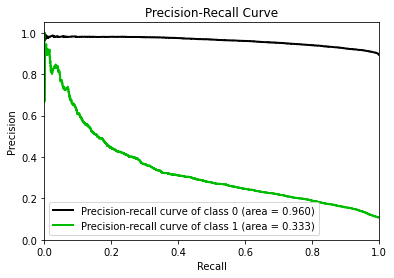

In [30]:
plot_precision_recall_curve(y_test, y_pred, curves='each_class')

### Calculate ROC AUC score

In [29]:
auc_roc = roc_auc_score(y_test, y_pred[:, 1])

print('The classifier obtains an AUC-ROC of {}.'.format(auc_roc))

The classifier obtains an AUC-ROC of 0.7686847867823527.


### Plot AUC-ROC curve

/Users/Sarah/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

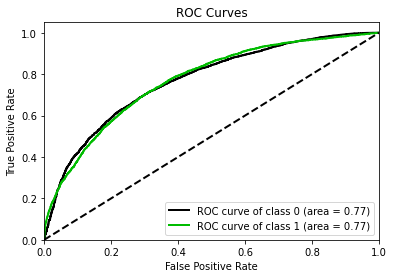

In [21]:
plot_roc_curve(y_test, y_pred, curves='each_class')

### Plot feature importance

In [36]:
importance = model.best_estimator_.feature_importances_
feature_names = X_train.columns
for i,v in enumerate(importance):
    print('Feature: %s, Score: %.5f' % (feature_names[i],v))

Feature: action_start_x, Score: 0.24322
Feature: action_start_y, Score: 0.11316
Feature: action_body_part_id, Score: 0.29843
Feature: action_start_distance, Score: 0.11273
Feature: angle, Score: 0.23246


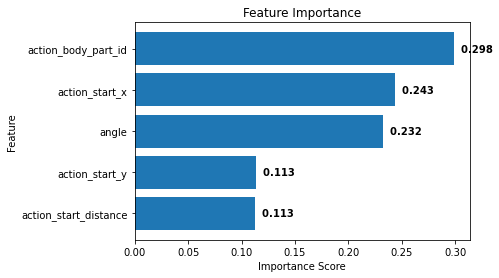

In [43]:
importance_plot = model.best_estimator_.feature_importances_
feature_names_plot = X_train.columns
sorted_idx = importance.argsort() # sort indices in descending order

plt.barh(feature_names[sorted_idx], importance[sorted_idx])
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance')

# Add labels to the bars
for i, v in enumerate(importance[sorted_idx]):
    plt.text(v, i, "  " + str(round(v, 3)), color='black', va='center', fontweight='bold')

plt.show()